# Read [SEAS5 Seasonal Forecast](https://www.ecmwf.int/sites/default/files/medialibrary/2017-10/System5_guide.pdf) COGs

This notebook demos basic functionality to read from our team's store of SEAS5 seasonal forecasts, stored as COGs and downloaded originally from the [ECMWF MARS service](https://www.ecmwf.int/en/forecasts/access-forecasts/access-archive-datasets).

In [12]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [13]:
import xarray as xr
import pandas as pd
import tqdm
import os
from dotenv import load_dotenv
from azure.storage.blob import ContainerClient
import rioxarray as rxr

load_dotenv()

DEV_BLOB_SAS = os.getenv("DSCI_AZ_SAS_DEV")
DEV_BLOB_NAME = "imb0chd0dev"
DEV_BLOB_URL = f"https://{DEV_BLOB_NAME}.blob.core.windows.net/"
GLOBAL_CONTAINER_NAME = "global"
DEV_BLOB_GLB_URL = DEV_BLOB_URL + GLOBAL_CONTAINER_NAME + "?" + DEV_BLOB_SAS

dev_glb_container_client = ContainerClient.from_container_url(DEV_BLOB_GLB_URL)

## 1. Load in all COGs from 2000 and join into a single `DataSet` object

Start by getting all the blob names from 2000

In [14]:
YEAR = 2000

blob_names = existing_files = [
    x.name
    for x in dev_glb_container_client.list_blobs(name_starts_with="mars/processed/")
    if str(YEAR) in x.name
]

# For a single year's worth of data there should be 12 months * 7 leadtimes' worth of data
assert len(blob_names) == (12 * 7)

Now we can loop through all of them and concatenate to create a single `DataSet` in `xarray`. 
 

In [15]:
das = []
for blob_name in tqdm.tqdm(blob_names):
    cog_url = (
        f"https://{DEV_BLOB_NAME}.blob.core.windows.net/global/"
        f"{blob_name}?{DEV_BLOB_SAS}"
    )

    # TODO: Probably need to play with these chunk sizes
    da_in = rxr.open_rasterio(
        cog_url, masked=True, chunks={"band": 1, "x": 225, "y": 900}
    )

    date_in = pd.to_datetime(blob_name.split(".")[0][-14:-4])
    leadtime = int(blob_name.split(".")[0][-1:])

    da_in = da_in.squeeze(drop=True)
    da_in["date"] = date_in
    da_in["leadtime"] = leadtime
    da_in = da_in.expand_dims(["date", "leadtime"])
    das.append(da_in)

    # Persisting to reduce the number of downstream Dask layers
    da_in = da_in.persist()
    das.append(da_in)

ds = xr.combine_by_coords(das)

100%|██████████| 84/84 [01:32<00:00,  1.10s/it]


In [16]:
ds

<xarray.DataArray (date: 12, leadtime: 7, y: 451, x: 900)> Size: 136MB
dask.array<concatenate, shape=(12, 7, 451, 900), dtype=float32, chunksize=(1, 1, 451, 225), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 7kB -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * y            (y) float64 4kB 90.0 89.6 89.2 88.8 ... -88.8 -89.2 -89.6 -90.0
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 96B 2000-01-01 2000-02-01 ... 2000-12-01
  * leadtime     (leadtime) int64 56B 0 1 2 3 4 5 6
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      tprate

## 2. Plot some sample data

For example, here is the forecast published in Jan 2000, for the following month (February, leadtime of 1):

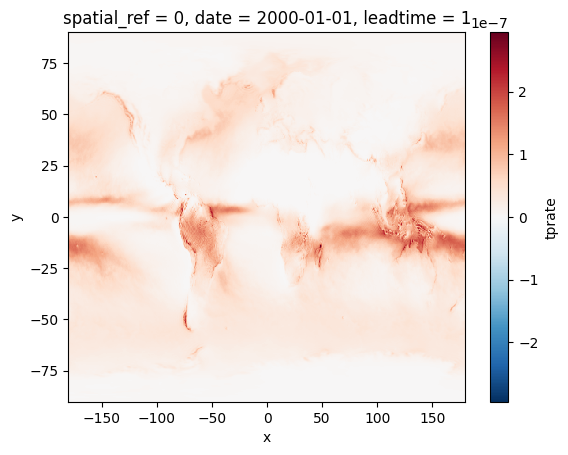

In [17]:
ds.sel({"date": "2000-01-01", "leadtime": 1}).plot()